In [71]:
import os
import numpy as np

import keras
from keras import losses
from keras import metrics
import keras.backend as K
from keras import initializers
from keras import regularizers
from keras.datasets import mnist
from keras.optimizers import Adam, SGD
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Activation, Lambda  
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D 

import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer

Before you begin, there will a lot of text for description but don't let that scare you. 
Longer description => more detail, that's all!

(More bluntly, hold off extensions requests till the last 3 days at least please)

# PART 2 - DCGAN

The first part of this assignment is coding up a DCGAN structure, this is a fairly standard network that you can look up online. 

This is an open ended part, you can look up the structure online and code and implement it with the functional API in Keras. It will involve setting up 3 primary things: 

There is no exactly correct network, as long as the network and code is correct, your hyperparameters are not important to your marks.

1. Adding the model structure generator 
2. Adding the model structure for the discriminator
3. Compling both models
4. Creating the training loop

The training loop in particular will be very different from what you're used to in previous assignments. 

https://towardsdatascience.com/understanding-generative-adversarial-networks-4dafc963f2ef

Use this as a useful resource to figure out how to set up the training loop, go over this blog, feel free to look at the code.

BUT BEFORE YOU RIP OFF THE CODE FROM THIS RESOURCE, bear in mind that this is for a GAN and not a DCGAN, we expect a GAN :) 

In [72]:
def generator():
    # Add generator code here
    model = Sequential([
        Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Reshape((7,7,128)),
        UpSampling2D(),
        Conv2D(64, 5, 5,border_mode='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        UpSampling2D(),
        Conv2D(1, 5, 5,border_mode='same', activation='tanh')
    ])
    return model

def discriminator():
    # Add discriminator code here
    model = Sequential([
        Conv2D(64, 5, 5, subsample=(2,2), input_shape=(28,28,1),border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Conv2D(128, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model



In [73]:
width = 28
height = 28
channels = 3
noise_dim = 10
shape = (28, 28, 1) #For MNIST data
optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)


In [74]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [75]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
# Scaling the range of the image to [-1, 1]
# Because we are using tanh as the activation function in the last layer of the generator
# and tanh restricts the weights in the range [-1, 1]
X_train = (X_train - 127.5) / 127.5

In [76]:
G = generator()
G.compile(loss='binary_crossentropy', optimizer=optimizer)
D = discriminator()
D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

dcgan = Sequential([G, D])
dcgan.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=optimizer)

/Users/Apple/anaconda3/envs/deepL/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation=<keras.lay..., padding="same")`
  
/Users/Apple/anaconda3/envs/deepL/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), activation="tanh", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/Users/Apple/anaconda3/envs/deepL/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(28, 28, 1..., activation=<keras.lay..., strides=(2, 2), padding="same")`
/Users/Apple/anaconda3/envs/deepL/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), activation=<keras.lay..., strides=(2, 2), padding="same")`


In [77]:
## ADD Code to Train DCGAN
def train(epoch=2, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            noise_input = np.random.rand(batch_size, 100)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # these are the predicted images from the generator
            predictions = G.predict(noise_input, batch_size=batch_size)
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            D.trainable = True
            D.train_on_batch(X, y_discriminator)
            
            # Let's train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            D.trainable = False
            dcgan.train_on_batch(noise_input, y_generator)



In [78]:
## Save Generator and discriminator models

In [79]:
# TRAIN YOUR DCGAN for exactly 2 EPOCHS here.
train(1, 128)
# For those more adventerous you can copy your code to Collab and actually train a model for 
# more EPOCHS to see how well it trains and test it with better results (recommended).



  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 1/468 [00:15<1:57:36, 15.11s/it]

  0%|          | 2/468 [00:18<1:30:15, 11.62s/it]

  1%|          | 3/468 [00:22<1:11:02,  9.17s/it]

  1%|          | 4/468 [00:25<57:49,  7.48s/it]  

  1%|          | 5/468 [00:29<49:01,  6.35s/it]

  1%|▏         | 6/468 [00:32<42:17,  5.49s/it]

  1%|▏         | 7/468 [00:36<37:24,  4.87s/it]

  2%|▏         | 8/468 [00:39<34:02,  4.44s/it]

  2%|▏         | 9/468 [00:43<31:41,  4.14s/it]

  2%|▏         | 10/468 [00:46<29:55,  3.92s/it]

  2%|▏         | 11/468 [00:49<28:42,  3.77s/it]

  3%|▎         | 12/468 [00:53<27:52,  3.67s/it]

  3%|▎         | 13/468 [00:56<27:14,  3.59s/it]

  3%|▎         | 14/468 [01:00<26:44,  3.53s/it]

  3%|▎         | 15/468 [01:03<26:22,  3.49s/it]

  3%|▎         | 16/468 [01:06<26:06,  3.47s/it]

  4%|▎         | 17/468 [01:10<25:55,  3.45s/it]

  4%|▍         | 18/468 [01:14<26:19,  3.51s/it]

  4%|▍         | 19/468 [01:17<26:10,  3.50s/it]

  4%|▍  

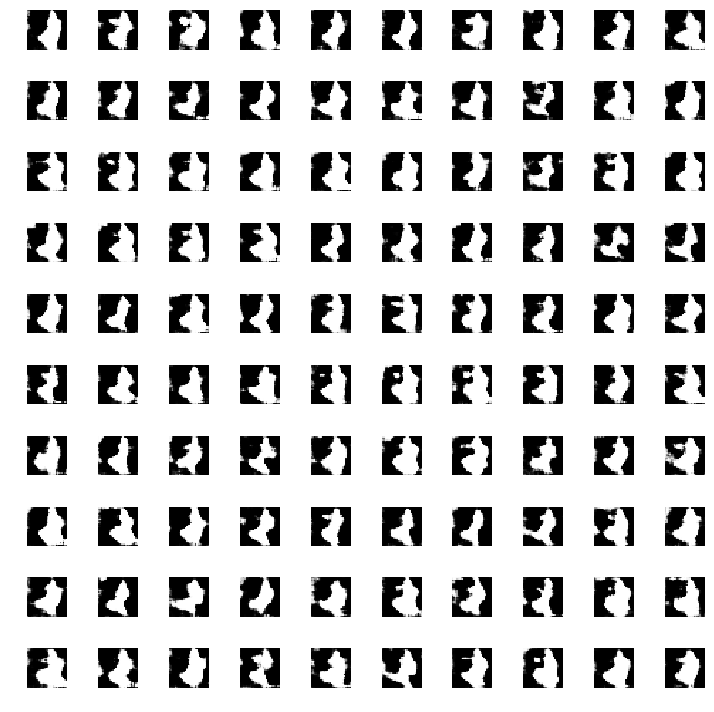

In [80]:
# ADD Code to Generate a sample images and visualize them. 
# Doesn't matter if your network didn't get anywhere in 2 EPOCHS, we're only checking your code not your results

# Sample generation of noise vector

import matplotlib.pyplot as plt

# noise = np.random.normal(0, 1, (samples, noise_dim))
# plt.plot(noise[0:3].T)
# plt.ylabel('some numbers')
# plt.show()


try_input = np.random.rand(100, 100)
preds = G.predict(try_input)

plt.figure(figsize=(10,10))
for i in range(preds.shape[0]):
    plt.subplot(10, 10, i+1)
    plt.imshow(preds[i, :, :, 0], cmap='gray')
    plt.axis('off')

# tight_layout minimizes the overlap between 2 sub-plots
plt.tight_layout()

#### Report

In your own words, summarize the model training process, how do the generator and the discriminator train together?

Generator generates images using random data. Discriminator checks if the input is real or not. Output of generatoris given as input to the discriminator and discriminator gives prediction whether it is real or not. Discriminator and generator keeps improving by weight updates. 